# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from unityagents import UnityEnvironment

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

##### select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

##### select this option to load version 2 (with 20 agents) of the environment
##### env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

In [2]:
env = UnityEnvironment(file_name='C:/Users/freed/codes_in_c_disk/deep-reinforcement-learning-master_origin/deep-reinforcement-learning-master/p2_continuous-control/Reacher_Windows_x86_64_task1/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
episode = 100
# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

In [6]:
import ppo_utils 
device = ppo_utils.device
policy=ppo_utils.Policy(state_size=33, action_size=4,seed = 2).to(device)

In [7]:
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-5)

C:\Users\freed\AppData\Roaming\Python\Python36\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\freed\codes_in_c_disk\deep-reinforcement-learning-master_origin\deep-reinforcement-learning-master\p2_continuous-control\sol_PPO\ppo_utils.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states, dtype=torch.float, device=device)


Episode: 20, score: 0.000000
[0.]


Episode: 40, score: 0.000000
[0.]


Episode: 60, score: 0.000000
[0.]


Episode: 80, score: 0.000000
[0.]


Episode: 100, score: 0.000000
[0.]


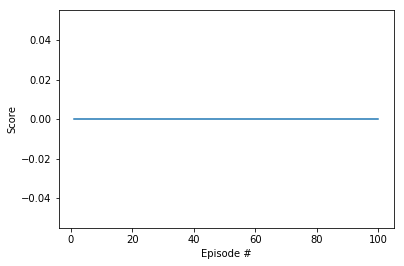

In [8]:
def PPO(n_episodes=episode, max_t=10**5, print_every=20,discount_rate = .999,epsilon = 0.1,beta = .01,SGD_epoch = 100):
    # keep track of progress
    mean_rewards = []


    for e in range(n_episodes):

        # collect trajectories
        old_log_probs, states, actions, rewards = \
            ppo_utils.collect_trajectories(env, policy, tmax=max_t)

        total_rewards = np.sum(rewards, axis=0)
        
        # states here is a list of tensor
        # we need from list of tensor to a single tensor for computing loss
        # since:ValueError: only one element tensors can be converted to Python scalars
        states = torch.stack(states)
        
        # gradient ascent step
        for _ in range(SGD_epoch):

            L = -ppo_utils.clipped_surrogate(policy, old_log_probs, states, actions, rewards,
                                              epsilon=epsilon, beta=beta)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L

        # the clipping parameter reduces as time goes on
        epsilon*=.999

        # the regulation term also reduces
        # this reduces exploration in later runs
        beta*=.995

        # get the average reward of the parallel environments
        mean_rewards.append(np.mean(total_rewards))

        # display some progress every 20 iterations
        if (e+1)%print_every ==0 :
            print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
            print(total_rewards)

        # update progress widget bar
        timer.update(e+1)

    timer.finish()
    
    return mean_rewards

scores = PPO()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
env.close()